In [56]:
import os, sys, glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import contextily as cx

import IR_processing_utils
import IR_corrections

from tqdm import tqdm


plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 7


### Настройка путей, параметров обработки и загрузка ИК снимков 

In [ ]:
# Здесь нужно указать путь к директории с данными. Есть следующие варианты:
# 1) путь к папке непосредственно со снимками (tiff) для конкретной миссии
# 2) путь к папке, в которой несколько подпапок для разных версий конвертации jpg->tiff. В таком случае подпапка указыватся data_subdir.
# 3) путь к папке, в которой несколько папок DJI* для случая, когда одна миссия снималась в несколько заходов (с заменой аккумулятора) 

#data_dir = r"M:\202404 Pleistocene Park\IR_mavic3\DJI_202404211121_009_Pleystocen-IRb"; flight_height = 160
#data_dir = r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\DJI_202404210937_006_Pleystocen-IR'; flight_height = 160
#data_dir = r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\DJI_202404211121_009_Pleystocen-IRb"; flight_height = 160

#data_dir = r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\DJI_202404221002_011_Pleystocen-IR3'; flight_height = 220
#data_dir = r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\DJI_202404221218_016_Pleystocen-IR3b'; flight_height = 220
#data_dir = r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\DJI_202404230843_017_Pleystocen-IR5'; flight_height = 230
#data_dir = r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\DJI_202404231239_024_Pleystocen-IR3'; flight_height = 220
#data_dir = r"G:\! Data\IFA\! campaigns\292406 Mukhrino\IR processing\2024.6.4\16_16\DJI_202406041912_048_muhrino-big-2"; flight_height = 150
#data_dir = r"G:\! Data\IFA\! campaigns\292406 Mukhrino\IR processing\2024.6.4\16_16\DJI_202406041941_049_muhrino-big-2"; flight_height = 150
#data_dir = r"G:\! Data\IFA\! campaigns\292406 Mukhrino\IR processing\2024.6.4\12_00\DJI_202406041528_045_muhrino-big-2"; flight_height = 150
#data_dir = r"G:\! Data\IFA\! campaigns\292406 Mukhrino\IR processing\2024.6.4\12_00\DJI_202406041458_044_muhrino-big-2"; flight_height = 150

#data_dir = r"M:\202408 Pleistocene Park\IR_Mavic3\11_02_evening"; flight_height = 220
#data_dir = r"G:\! Data\IFA\! campaigns\202408 Pleistocene Park\IR_Mavic3\1208_day_IR3"; flight_height = 220
#data_dir = r"G:\! Data\IFA\! campaigns\202408 Pleistocene Park\IR_Mavic3\1208_day_IR3b"; flight_height = 220
data_dir = r"G:\! Data\IFA\! campaigns\202408 Pleistocene Park\IR_Mavic3\1208_evening_IR3"; flight_height = 220
#data_dir = r"G:\! Data\IFA\! campaigns\202408 Pleistocene Park\IR_Mavic3\1208_evening_IR3b"; flight_height = 220

#data_dir = r"G:\! Data\IFA\! campaigns\202503 Ayhal\Mavic_IR_imaging\20250327_evn"; flight_height = 370
#data_dir = r"G:\! Data\IFA\! campaigns\202503 Ayhal\Mavic_IR_imaging\20250328_morning"; flight_height = 630

#data_dir = r"M:\202507 Ingilor\Mavic3_IR\20250717_Vol2_evening"; flight_height = 280

#data_dir = r"M:\202507 Ingilor\Mavic3_IR\20250718_no3_Vol1a_noshield"; flight_height = 300
#data_dir = r"M:\202507 Ingilor\Mavic3_IR\20250718_no4_Vol1a_shield"; flight_height = 300



# Имя подпапки с тифами (если подпаки нет, указать None). Актуально например при наличие разных версий конвертации jpg->tiff. 
data_subdir = 'tiffs_thermal_parser, emis = 1.00'
#data_subdir = None

sensor_size = [6.144, 7.68] #Mavic sensor size in mm

# Настройки алгоритма коррекции
corr_opts = {'diff_func': IR_processing_utils.img_diff_SIFT, 
             'detrend': True, 
             'use_L0': True,
             'L0_args': {'sm_radius': 50},
             'L2_args': {'wnd_size': 9, 'n_steps': 3},
             'L3_args': {'wnd_size': 9, 'n_steps': 5},
             'L4_args': {'wnd_size': 5}}

#***************************************************************************************************

opts_str = 'detrend=%d, use_L0=%d, diff=%s'%(corr_opts['detrend'],corr_opts['use_L0'], corr_opts['diff_func'].__name__.replace('img_diff_', ''))

dji_subdirs = glob.glob (data_dir + '\\DJI*')
dji_subdirs = [x for x in dji_subdirs if os.path.isdir(x)]

if len (dji_subdirs) == 0:
    dji_subdirs = [data_dir]

img_array = {}
for i, dji_subdir in enumerate (dji_subdirs):
    display(dji_subdir)
    if data_subdir is not None:
        data_dir_src = dji_subdir + '/' + data_subdir + '/'
    else:
        data_dir_src = dji_subdir + '/'

    cur_array, cur_df = IR_processing_utils.read_IR_images (data_dir_src, n_jobs = 1)
    #cur_df['folder'] = data_dir_src
    if i == 0:
        img_array['t_raw'] = cur_array
        img_df = cur_df
    else:
        img_array['t_raw'] = np.concatenate((img_array['t_raw'], cur_array), axis=2)
        img_df = pd.concat((img_df, cur_df), ignore_index = True)
    

img_shape = img_array['t_raw'].shape
img_N = img_df.shape[0]

img_df = IR_processing_utils.calc_azimuth4df (img_df)
img_df = IR_processing_utils.init_polygons4df (img_df, sensor_size, flight_height)

display(img_df.head())

pics_dir = data_dir + '/processing_pics' + (('_' + data_subdir) if data_subdir is not None else '') + '/'
if not os.path.isdir (pics_dir):
    os.mkdir (pics_dir)

save_dir = pics_dir + '/corr_with_L0_new/'
if not os.path.isdir (save_dir):
    os.mkdir (save_dir)


'G:\\! Data\\IFA\\! campaigns\\202408 Pleistocene Park\\IR_Mavic3\\1208_day_IR3b\\DJI_202408121108_199_Pleystocen-IR3b'

file    gps_lat     gps_lon  Image ImageWidth  \
0  DJI_20240812111058_0001_T.tiff  68.510330  161.513175             640.0   
1  DJI_20240812111100_0002_T.tiff  68.510362  161.513180             640.0   
2  DJI_20240812111102_0003_T.tiff  68.510478  161.513222             640.0   
3  DJI_20240812111104_0004_T.tiff  68.510665  161.513286             640.0   
4  DJI_20240812111105_0005_T.tiff  68.510896  161.513365             640.0   

   Image ImageLength  Image BitsPerSample  Image Compression  \
0              512.0                 32.0                1.0   
1              512.0                 32.0                1.0   
2              512.0                 32.0                1.0   
3              512.0                 32.0                1.0   
4              512.0                 32.0                1.0   

   Image PhotometricInterpretation Image ImageDescription Image Make  ...  \
0                              1.0               WhiteHot        DJI  ...   
1                              1.0               WhiteHot        DJI  ...   
2                              1.0               WhiteHot        DJI  ...   
3                              1.0               WhiteHot        DJI  ...   
4                              1.0               WhiteHot        DJI  ...   

  EXIF LensSpecification                                             folder  \
0                    9.1  G:\! Data\IFA\! campaigns\202408 Pleistocene P...   
1                    9.1  G:\! Data\IFA\! campaigns\202408 Pleistocene P...   
2                    9.1  G:\! Data\IFA\! campaigns\202408 Pleistocene P...   
3                    9.1  G:\! Data\IFA\! campaigns\202408 Pleistocene P...   
4                    9.1  G:\! Data\IFA\! campaigns\202408 Pleistocene P...   

   gps_azimuth     min_lon     max_lon    min_lat    max_lat  delta_lon  \
0     3.077408  161.510906  161.515445  68.509664  68.510996    0.00454   
1     7.465460  161.510910  161.515450  68.509697  68.511028    0.00454   
2     7.235509  161.510952  161.515492  68.509812  68.511144    0.00454   
3     7.073011  161.511016  161.515556  68.509999  68.511331    0.00454   
4     6.969245  161.511095  161.515635  68.510230  68.511562    0.00454   

   delta_lat                                            Polygon  
0   0.001332  POLYGON ((161.51544544455217 68.51099567313898...  
1   0.001332  POLYGON ((161.51545022564795 68.51102822873692...  
2   0.001332  POLYGON ((161.51549168165047 68.51114408982613...  
3   0.001332  POLYGON ((161.51555642274025 68.51133083973654...  
4   0.001332  POLYGON ((161.5156345848246 68.51156153420436,...  

[5 rows x 68 columns]

### Идентификация полос сканирования (важно для этапа коррекции №4)

identify_swaths4df(): segment 0 reached 29 with mean_az 6

identify_swaths4df(): segment 1 reached -33 with mean_az 188

identify_swaths4df(): segment 2 reached 27 with mean_az 6

identify_swaths4df(): segment 3 reached -31 with mean_az 188

identify_swaths4df(): segment 4 reached 27 with mean_az 6

identify_swaths4df(): segment 5 reached -32 with mean_az 187

identify_swaths4df(): segment 6 reached 27 with mean_az 6

identify_swaths4df(): segment 7 reached -31 with mean_az 187

identify_swaths4df(): segment 8 reached 27 with mean_az 5

identify_swaths4df(): segment 9 reached -33 with mean_az 188

identify_swaths4df(): segment 10 reached 27 with mean_az 6

identify_swaths4df(): segment 11 reached -34 with mean_az 187

identify_swaths4df(): segment 12 reached 27 with mean_az 7

identify_swaths4df(): segment 13 reached -39 with mean_az 187

identify_swaths4df(): segment 14 reached 28 with mean_az 5

identify_swaths4df(): segment 15 reached -33 with mean_az 187

identify_swaths4df(): segm

C:\Users\mvar9\AppData\Local\Temp\ipykernel_27844\288132402.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


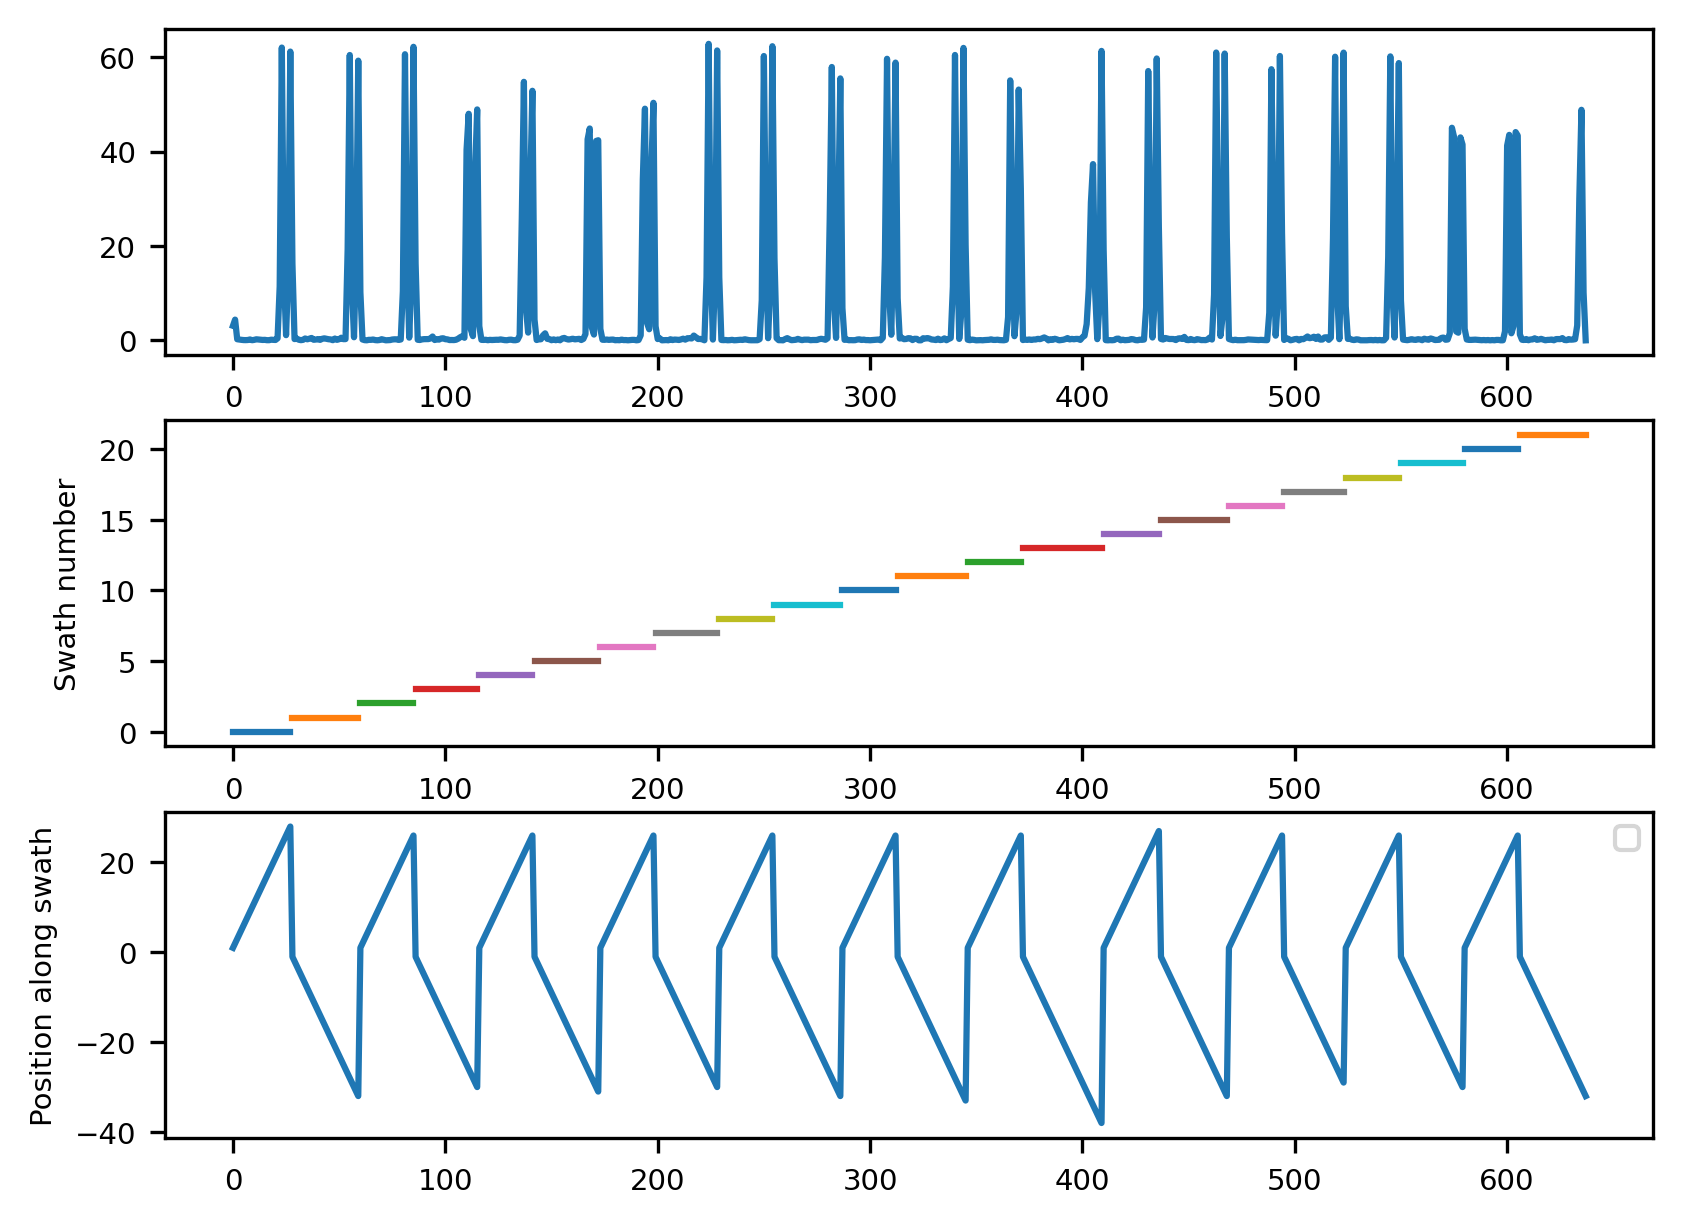

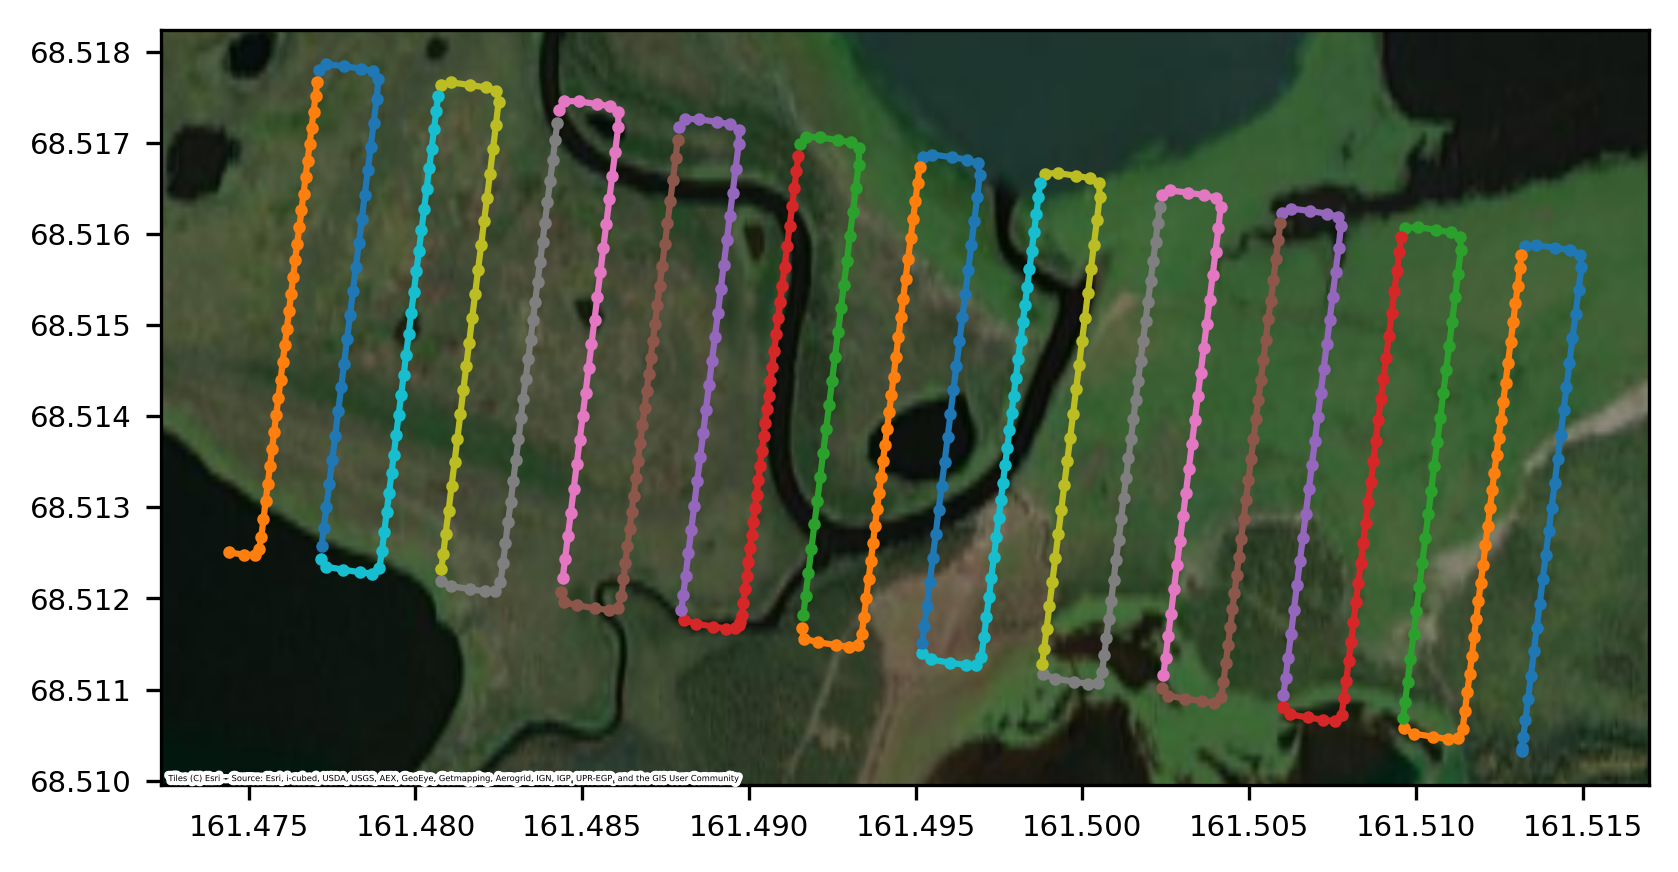

In [58]:
img_df = IR_processing_utils.identify_swaths4df(img_df, min_segment_len = 3, crit_delta_az=160)
    
f, ax = plt.subplots (3,1)
x = img_df.index.to_numpy()

#ax[0].plot (x, img_df['gps_azimuth'], label = 'azimuth')
ax[0].plot (x, img_df['delta_az'], label = 'change of azimuth')
plt.legend()

unique_ids = np.unique(img_df['swath_id'])
for id in unique_ids:
    ax[1].plot (x[img_df['swath_id'] == id], img_df['swath_id'][img_df['swath_id'] == id])
ax[1].set_ylabel ('Swath number')

ax[2].plot (x, img_df['swath_pos'])
ax[2].set_ylabel ('Position along swath')

plt.savefig(save_dir + 'swath_plot.png')


plt.figure()
for id in unique_ids:
    idx = np.where(img_df['swath_id'] == id)[0]
    plt.plot (img_df['gps_lon'][idx], img_df['gps_lat'][idx], '-o', markersize=2)

try:
    cx.add_basemap(plt.gca(), source = cx.providers.Esri.WorldImagery, crs = 4326, attribution_size = 2)    
except:
    pass
plt.gca().set_aspect(1.0/np.cos(img_df['gps_lat'].mean()*np.pi/180))

plt.savefig(save_dir + 'swath_map.png')



### Этап коррекции L0. Удаление систематического смещения температуры в зависимости от положения пиксела в пределах снимка.

100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


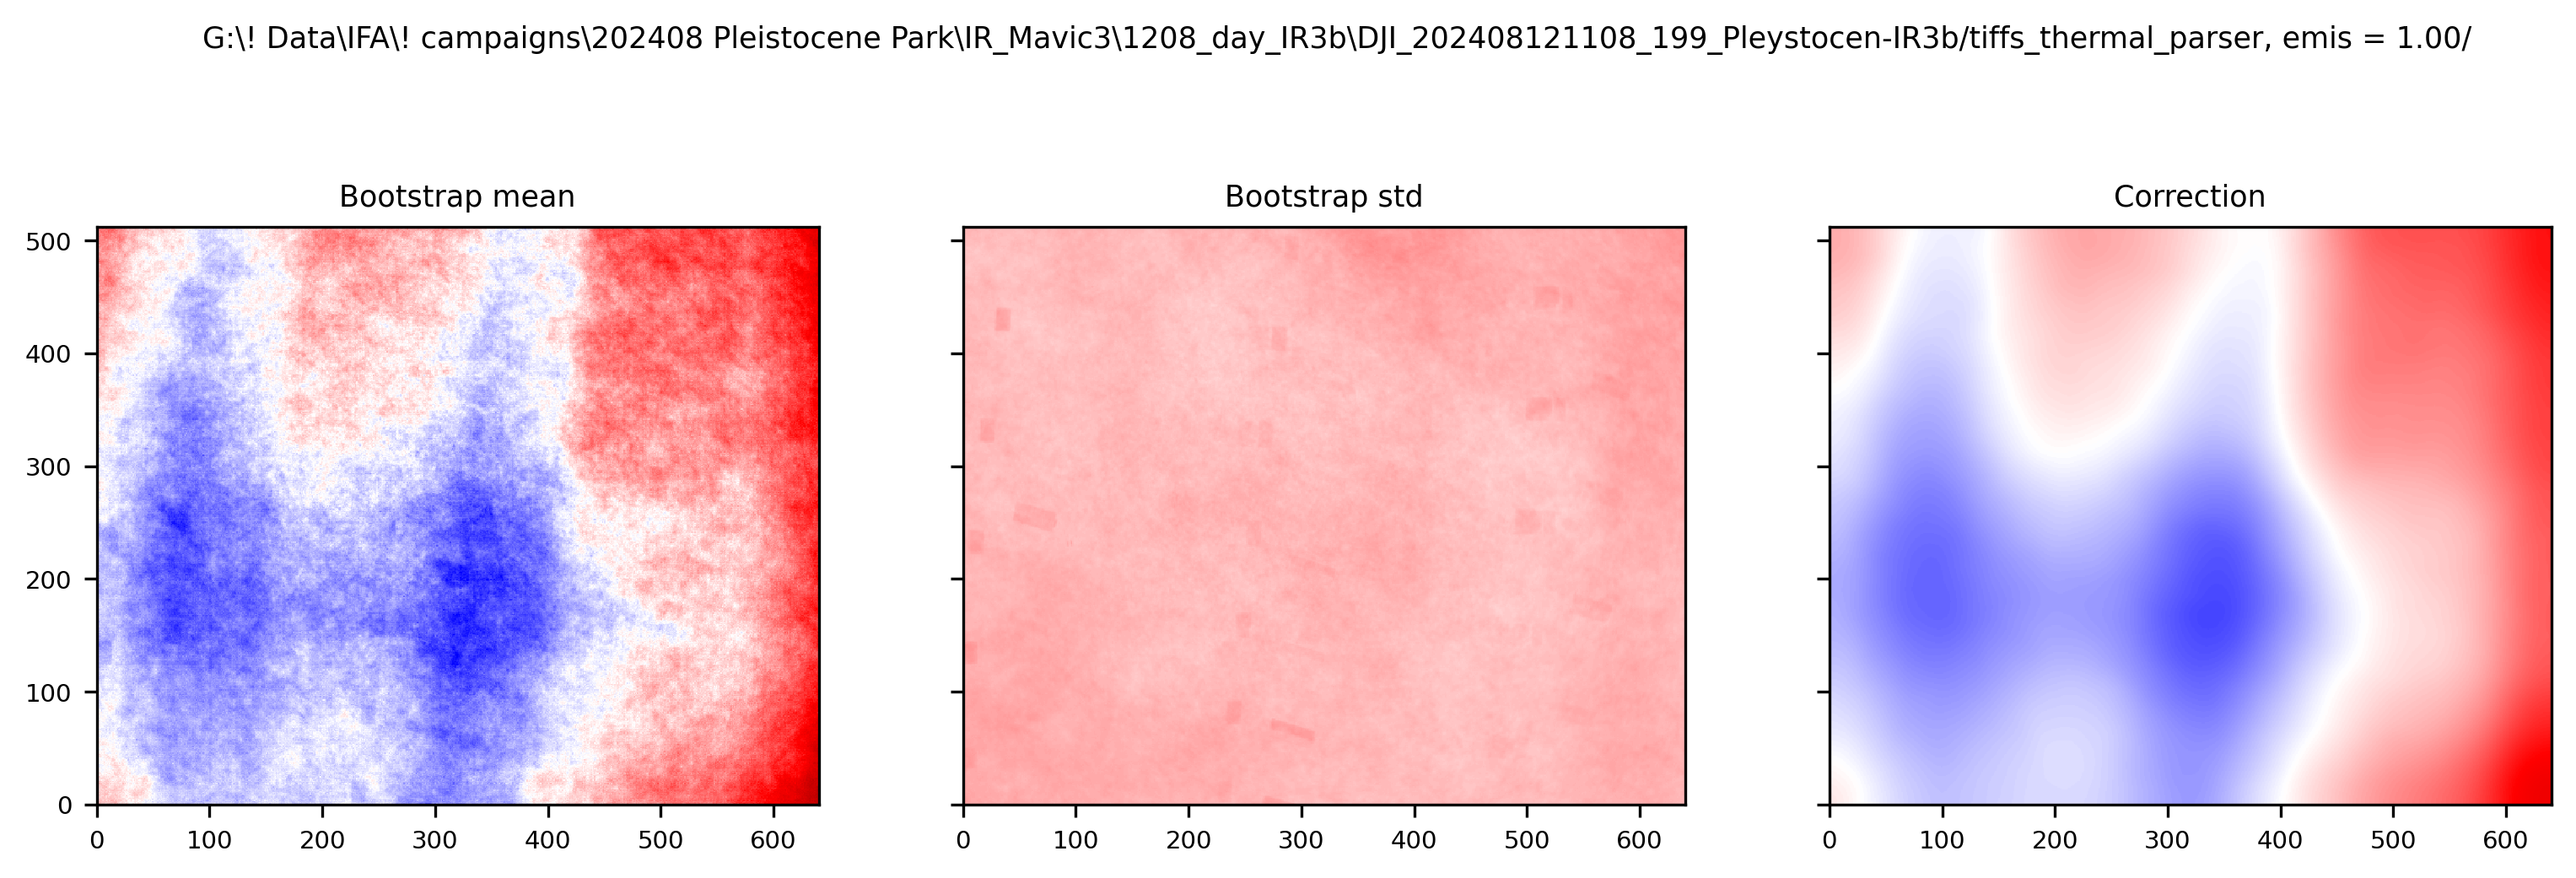

In [59]:
img_array['t0']  = IR_corrections.run_L0_corr (img_array['t_raw'], img_df, pics_dir=save_dir, **corr_opts['L0_args'])

### Расчет матрицы разностей температуры между пересекающимися областями различных снимков

In [60]:
import importlib
importlib.reload (IR_processing_utils)

if corr_opts['use_L0']:
    t0_source = 't0'
else:
    t0_source = 't_raw'

diff_matrix = {}

reload_pkl = False
pkl_path = data_dir + '\\diff_matrix_%s, h = %d'%(t0_source, flight_height) + ', diff=' + corr_opts['diff_func'].__name__.replace('img_diff_', '') + '.pkl'

if not os.path.isfile (pkl_path):
    reload_pkl = True
if reload_pkl:
    diff_matrix['t0'], diff_weights = IR_processing_utils.calc_diff_matrix (img_array[t0_source], img_df, diff_func=corr_opts['diff_func'])
    IR_processing_utils.try_dump_pkl ((diff_matrix[t0_source], diff_weights), pkl_path)
else:
    (diff_matrix[t0_source], diff_weights) = IR_processing_utils.try_load_pkl(pkl_path)


100%|██████████| 638/638 [26:25<00:00,  2.49s/it]


In [61]:
#раскометировать и запустить, если матрица рассчиталась, но не сохранилась в pickle-файл

# with open(pkl_path, 'wb') as handle:
#        pickle.dump((diff_matrix[t0_source], diff_weights), handle, protocol=pickle.HIGHEST_PROTOCOL) 

### Этап коррекции L1. Идентификация резких скачкаобразных изменений температуры между последовательным снимками. 

'n_outliers = 13, max_diff = 1.929977'

'n_outliers = 2, max_diff = 0.495289'

'n_outliers = 1, max_diff = 0.357340'

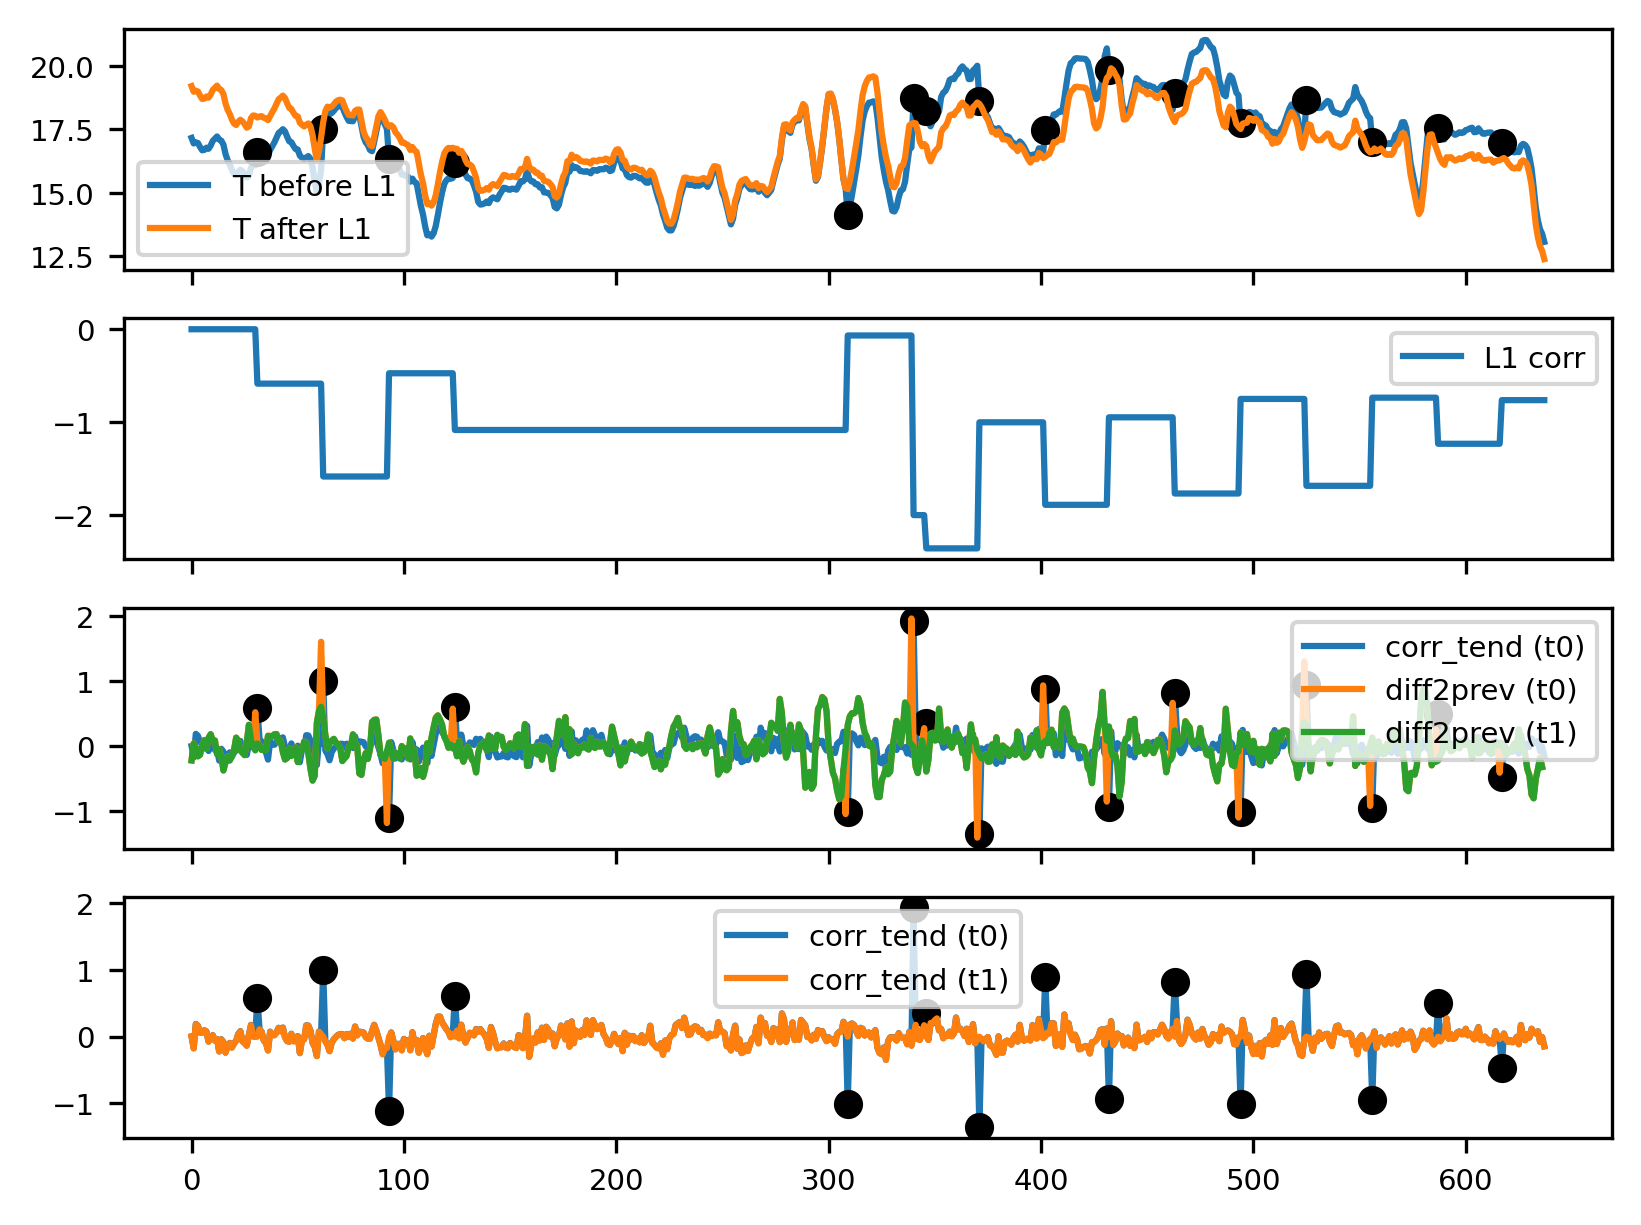

In [62]:
import importlib
importlib.reload(IR_corrections)

img_array['t1'], diff_matrix['t1'] = IR_corrections.run_L1_corr (img_array[t0_source], diff_matrix[t0_source],
                                                                 corr_opts['detrend'], pics_dir = save_dir, fig_name = 'L1_corr', opts_str = opts_str)


### Этап коррекции L2. Коррекция плавных смещений температуры между последовательными снимками 

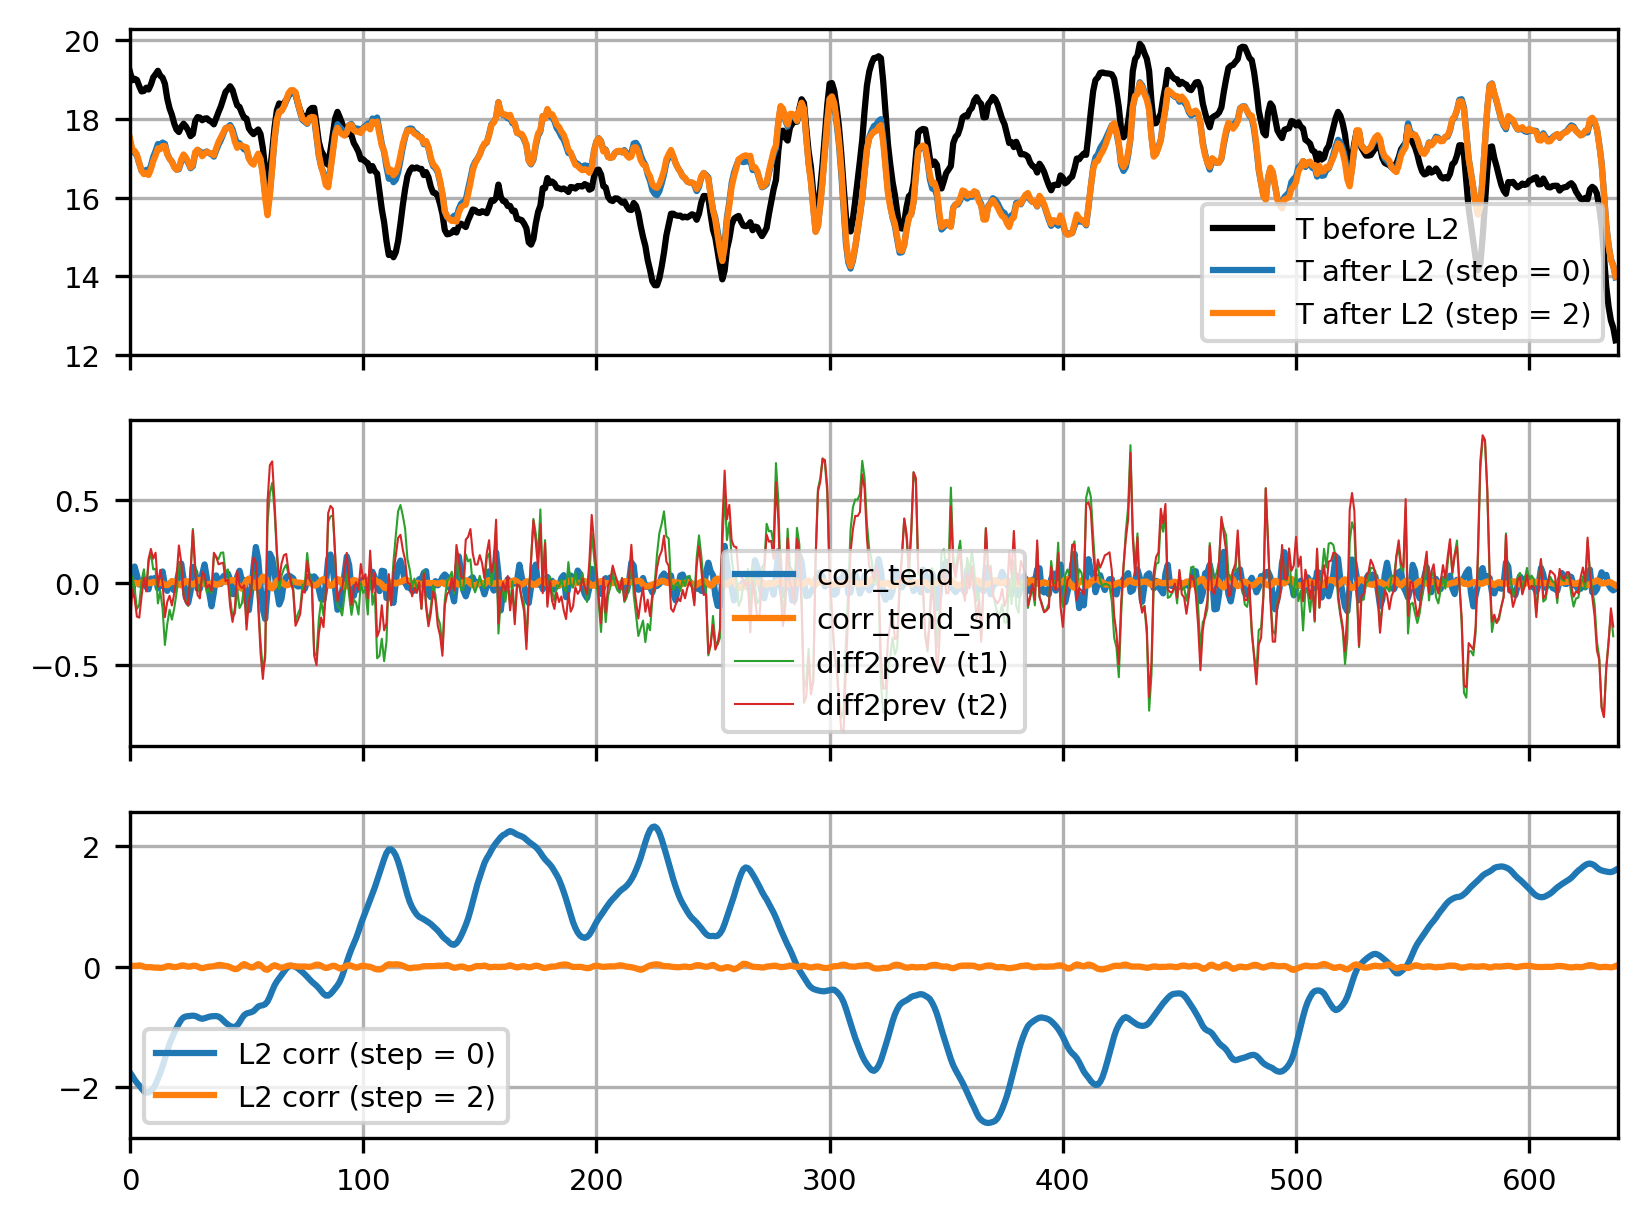

In [63]:
img_array['t2'], diff_matrix['t2'] = IR_corrections.run_L2_corr (img_array['t1'], diff_matrix['t1'],
                                                                 corr_opts['detrend'], pics_dir = save_dir, 
                                                                 fig_name = 'L2_corr', opts_str = opts_str,
                                                                 **corr_opts['L2_args'])


### Этап коррекции L3. Коррекция смещений между пересекающими областями снимков в соседних полосах сканирования.

100%|██████████| 638/638 [00:00<00:00, 4031.66it/s]


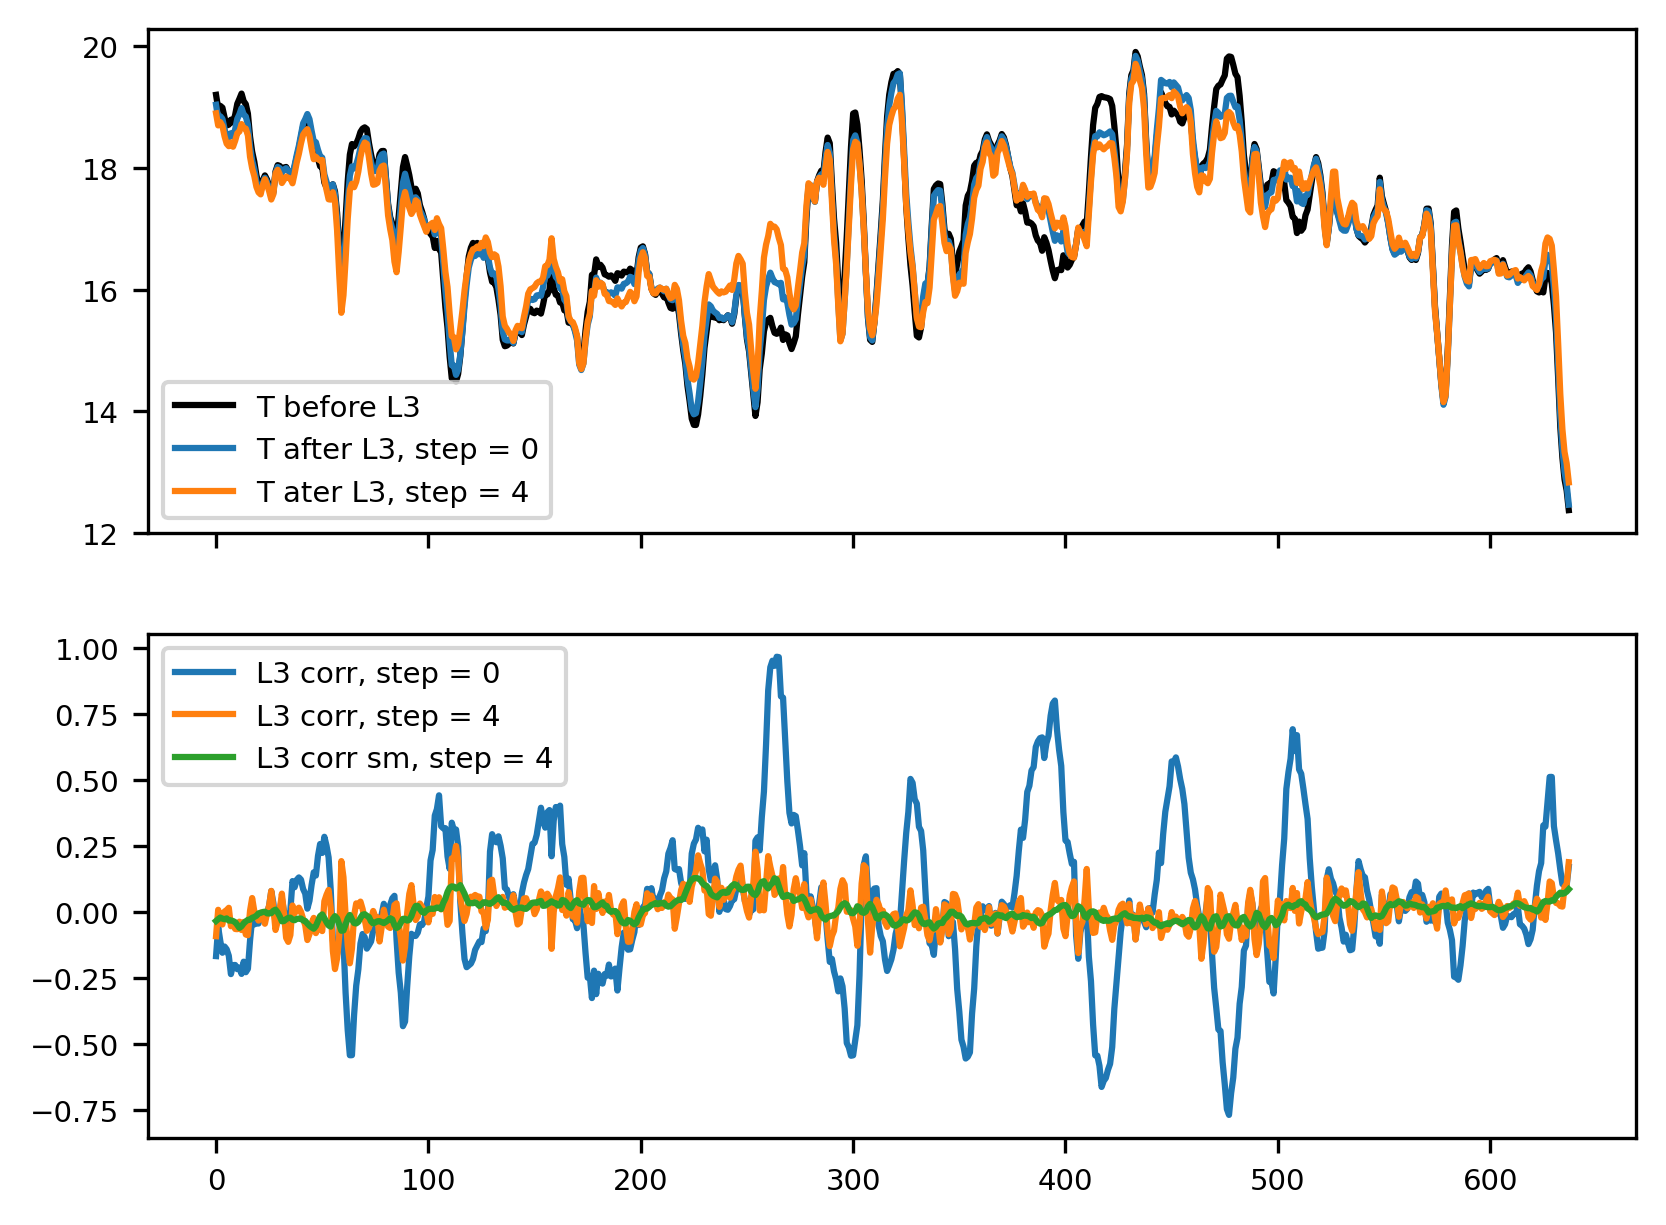

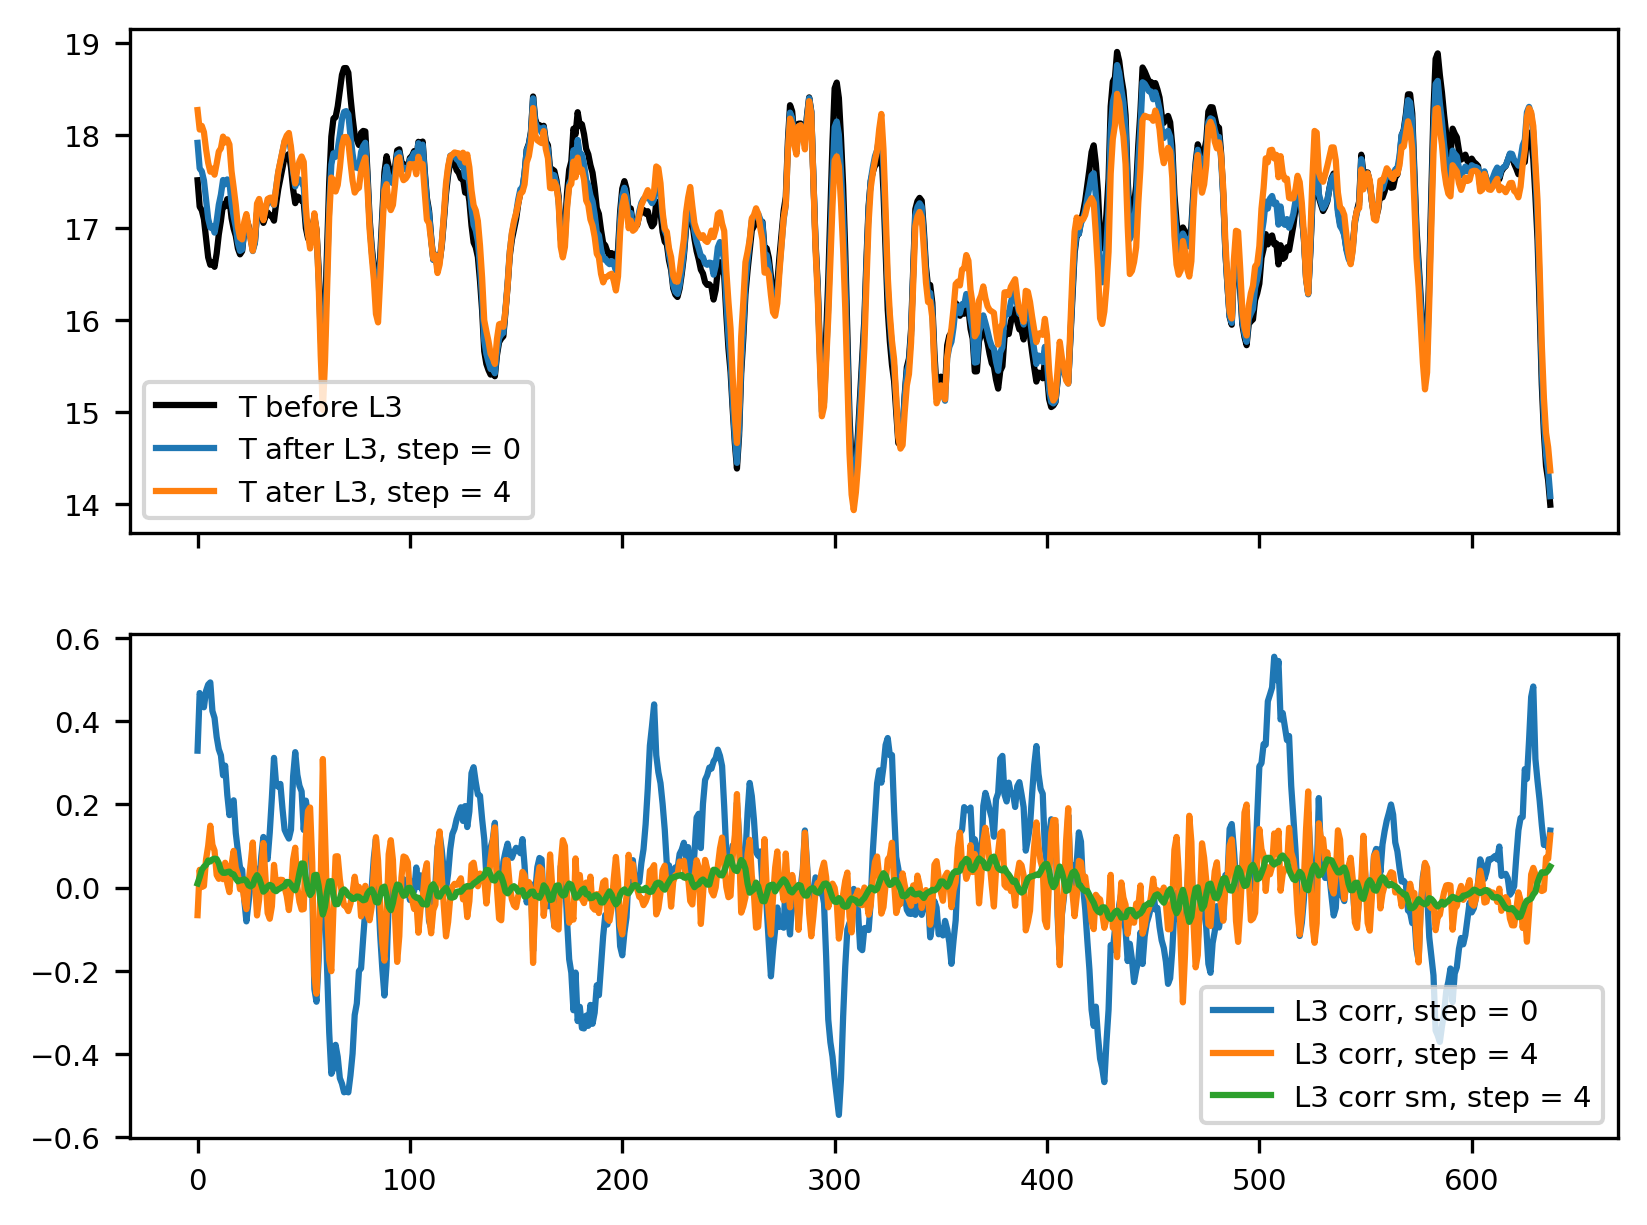

In [64]:
img_array['t31'], diff_matrix['t31'] = IR_corrections.run_L3_corr (img_array['t1'], img_df, diff_matrix['t1'], diff_weights,
                                                                   pics_dir = save_dir, fig_name = 'L31_corr', opts_str = opts_str, **corr_opts['L3_args'])

img_array['t32'], diff_matrix['t32'] = IR_corrections.run_L3_corr (img_array['t2'], img_df, diff_matrix['t2'], diff_weights,
                                                                   pics_dir = save_dir, fig_name = 'L32_corr', opts_str = opts_str, **corr_opts['L3_args'])




### Этап коррекции L4. Удаление систематического тренда изменения температуры вдоль полосы сканирования (отдельно для двух направлений движения дрона). Применяется как альтернатива этапу L2.

In [65]:
corr_opts3431 = corr_opts | {'L3_args': corr_opts['L3_args'] | {'n_steps': 1}}
#corr_opts3431['L3_args']['n_steps'] = 1
corr_opts

{'diff_func': <function IR_processing_utils.img_diff_SIFT(img_array, img_df, i1, i2, draw_figure=False)>,
 'detrend': True,
 'use_L0': True,
 'L0_args': {'sm_radius': 50},
 'L2_args': {'wnd_size': 9, 'n_steps': 3},
 'L3_args': {'wnd_size': 9, 'n_steps': 5},
 'L4_args': {'wnd_size': 5}}

c:\Users\mvar9\anaconda3\envs\GIS\Lib\site-packages\lowess\lowess.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.9126826742109' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  ySmooth[index] = wLstSqReg(x[points], y[points], polynomialDegree,
c:\Users\mvar9\anaconda3\envs\GIS\Lib\site-packages\lowess\lowess.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.672197527144053' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  ySmooth[index] = wLstSqReg(x[points], y[points], polynomialDegree,
100%|██████████| 638/638 [00:00<00:00, 4044.81it/s]


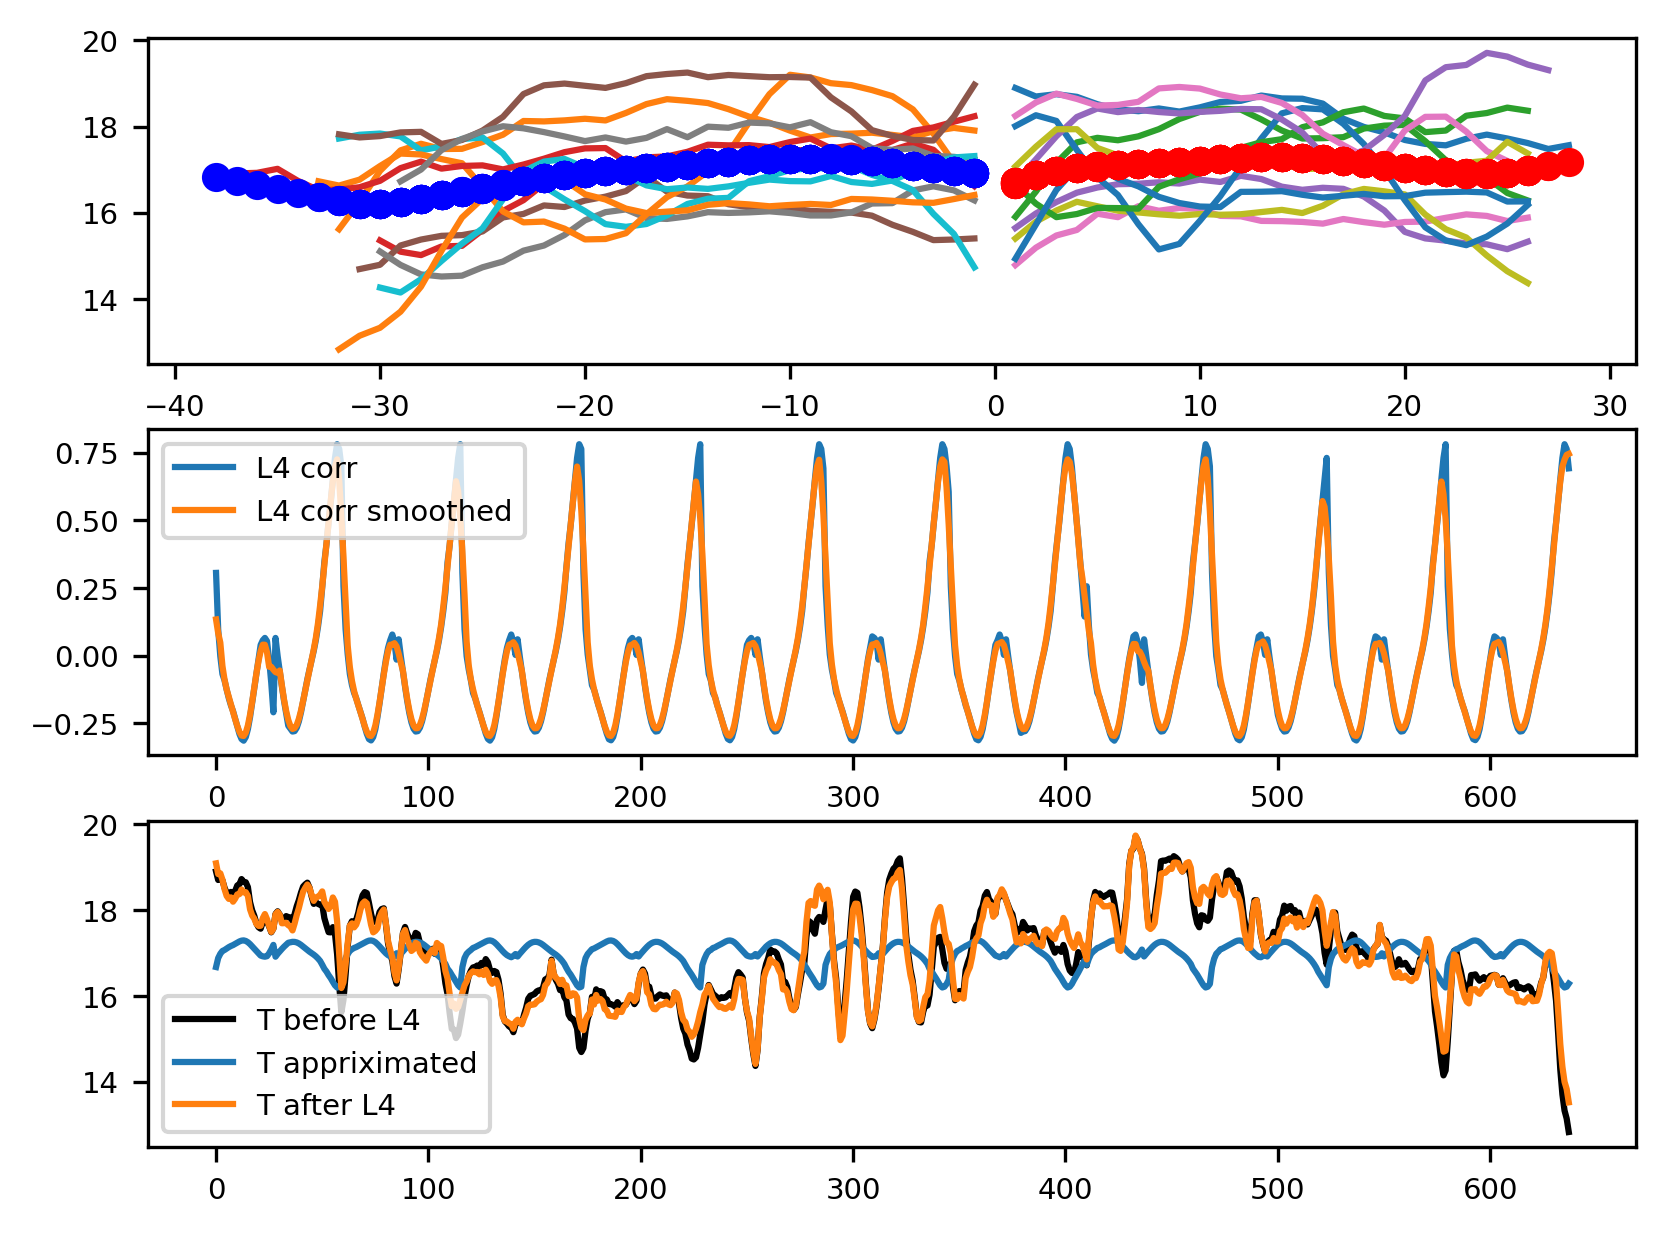

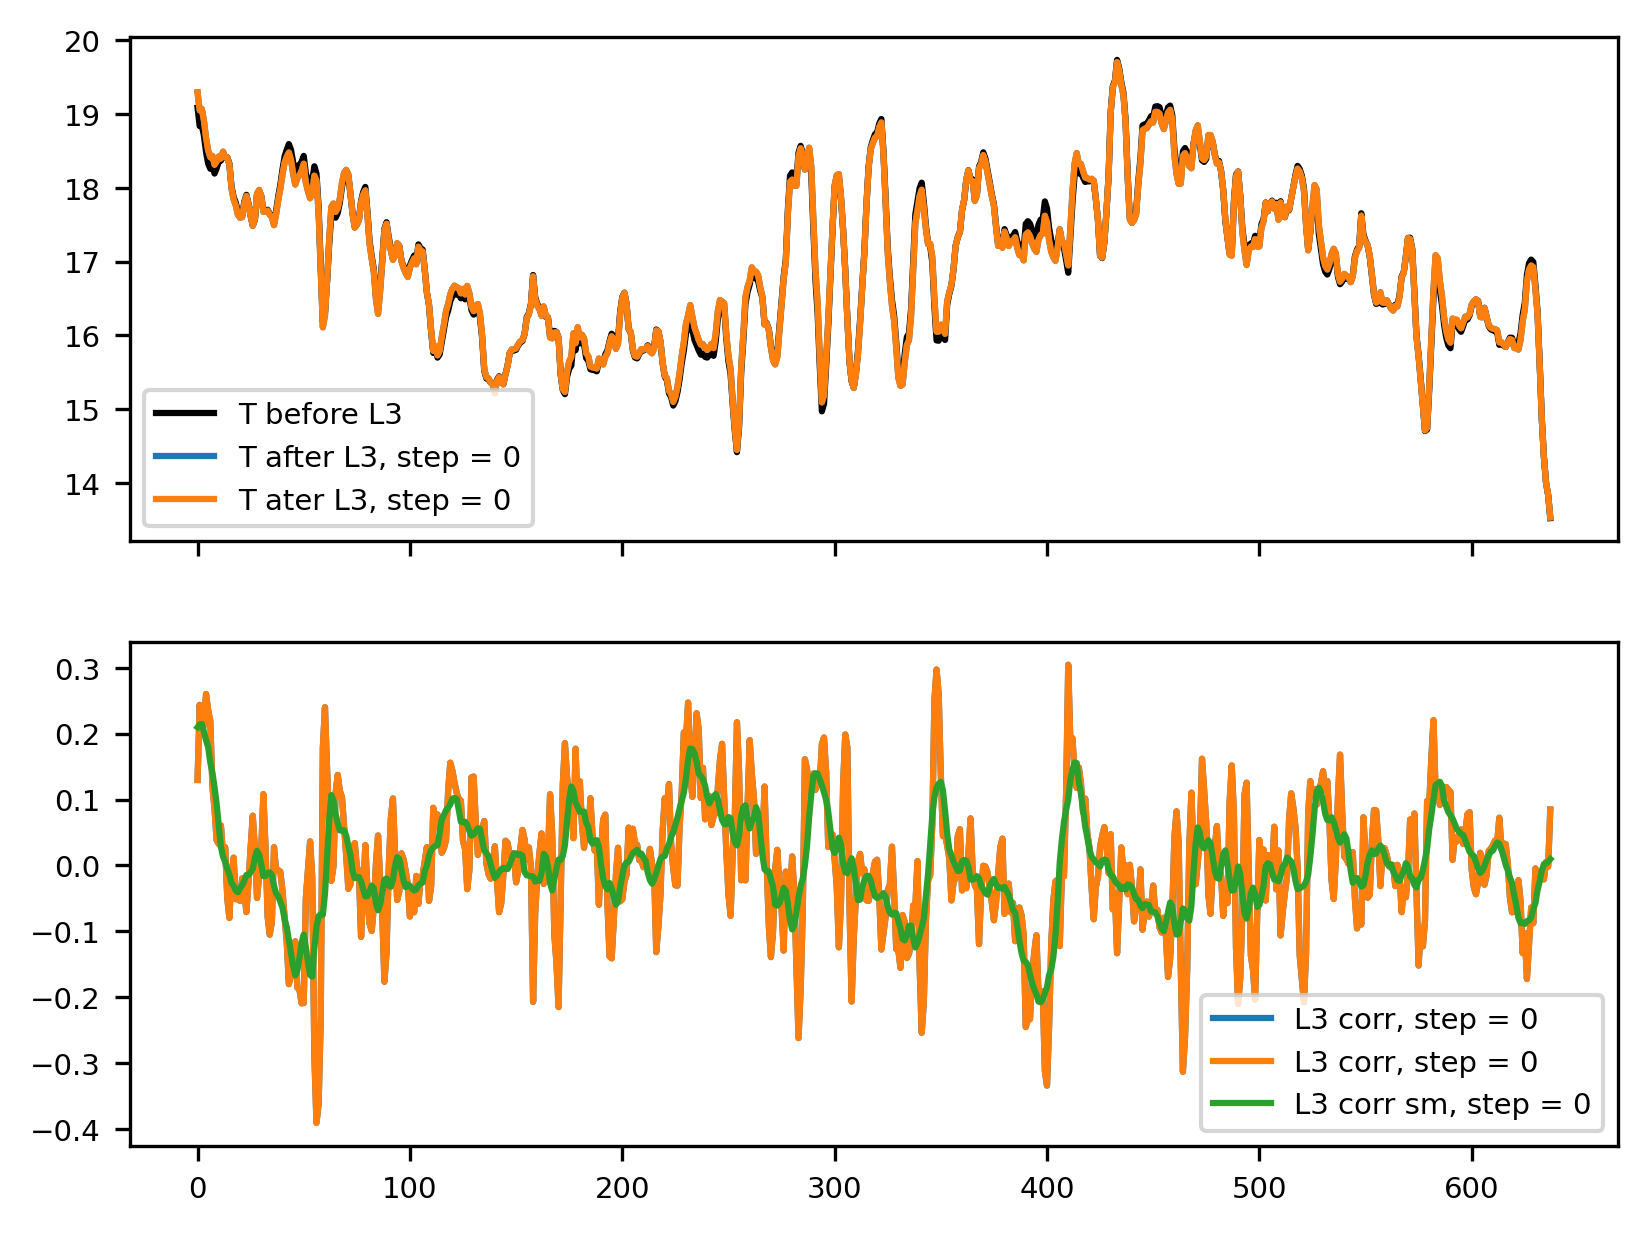

In [66]:
img_array['t431'], diff_matrix['t431'] = IR_corrections.run_L4_corr (img_array['t31'], img_df, diff_matrix['t31'], corr_opts['detrend'],
                                                                     pics_dir = save_dir, opts_str = opts_str, fig_name = 'L4_corr', **corr_opts['L4_args']) #, corr_opts['L4_wnd'])


img_array['t3431'], diff_matrix['t3431'] = IR_corrections.run_L3_corr (img_array['t431'], img_df, diff_matrix['t431'], diff_weights, 
                                                                      pics_dir = save_dir, fig_name = 'L3431_corr', opts_str = opts_str, **(corr_opts['L3_args'] | {'n_steps': 1}))



100%|██████████| 20/20 [01:04<00:00,  3.23s/it]


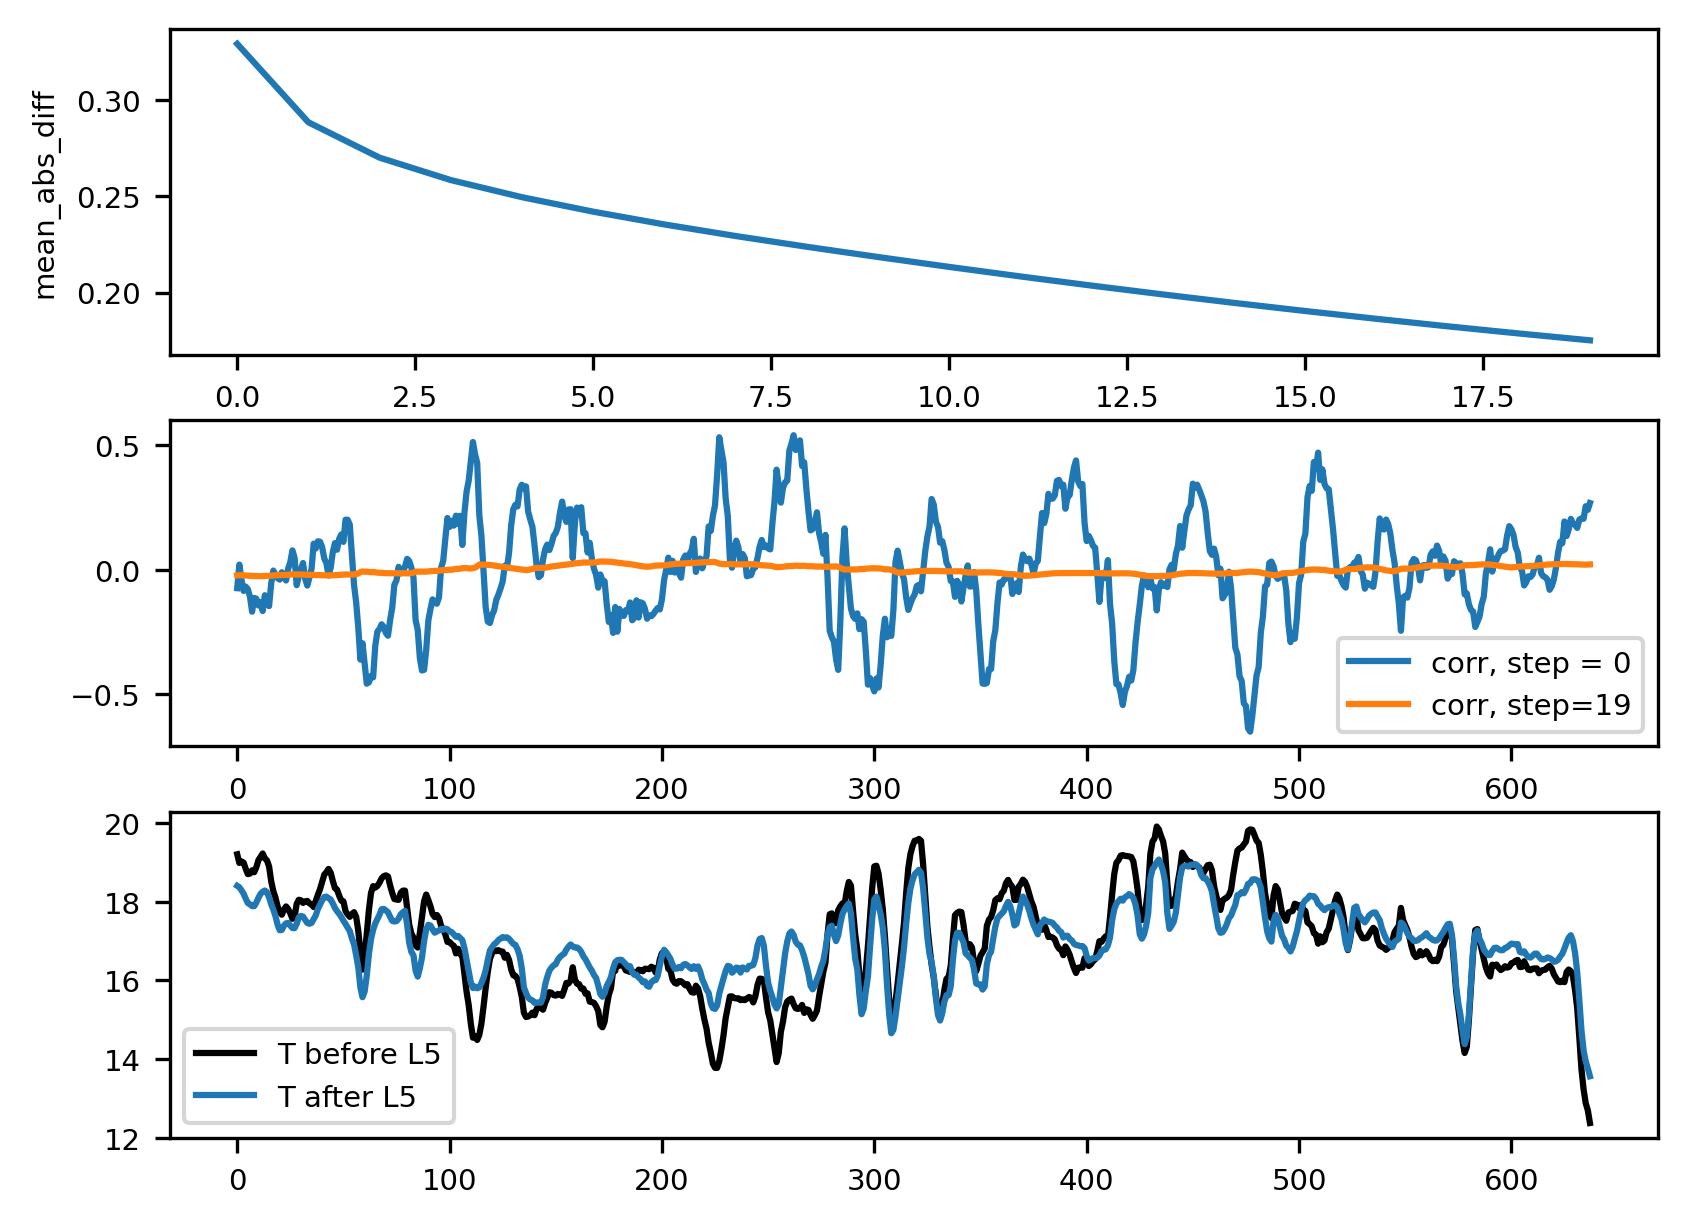

In [67]:
importlib.reload(IR_corrections)
img_array['t51'], diff_matrix['t51'] = IR_corrections.run_L5_corr (img_array['t1'], img_df, diff_matrix['t1'], 
                                                                   pics_dir = save_dir, opts_str = opts_str)


### Визуализация средней температуры по снимкам на различных шагах алгоритма коррекции

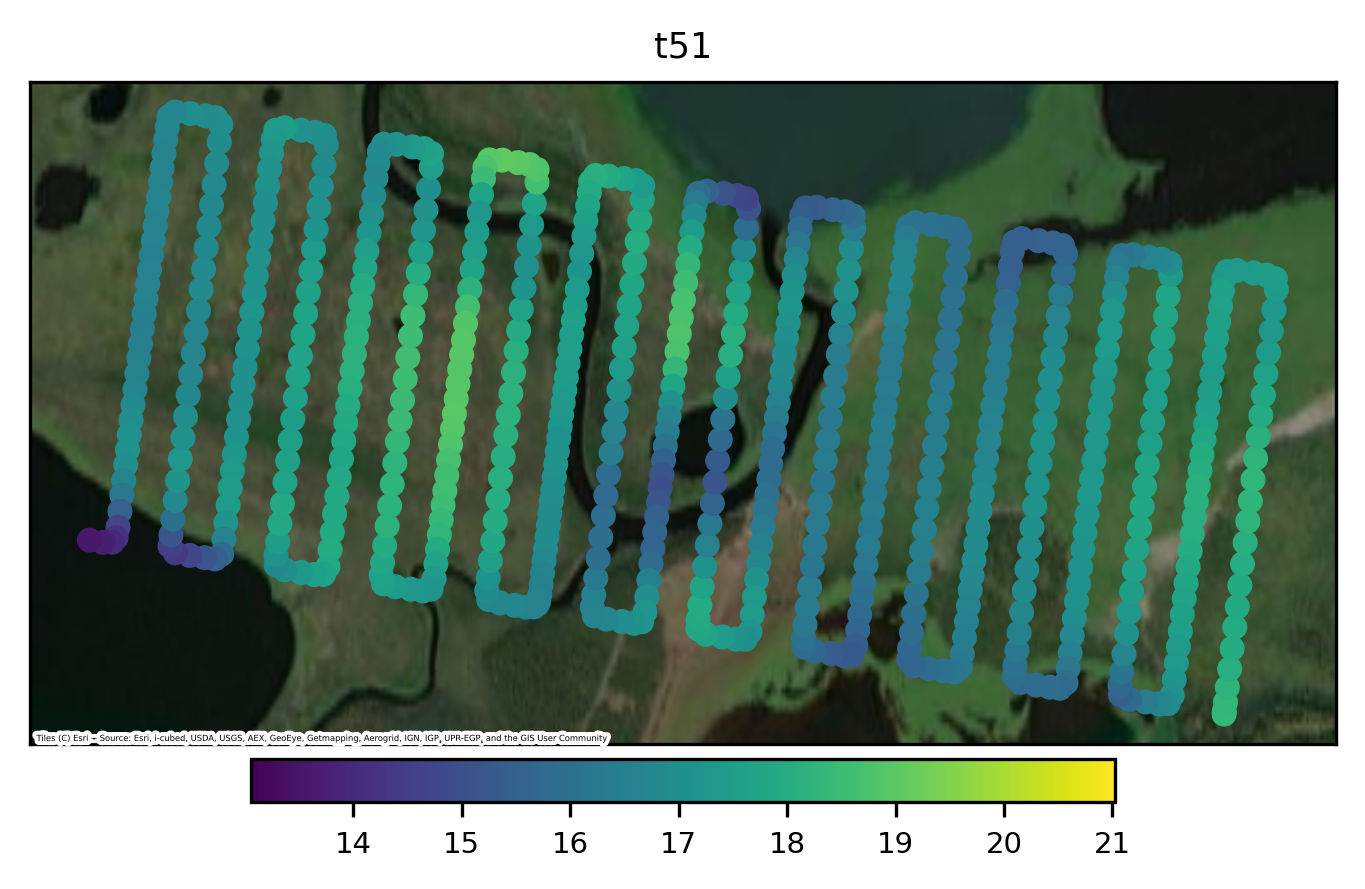

In [68]:
extent_x = (img_df['gps_lon'].max() - img_df['gps_lon'].min()) * np.cos(img_df['gps_lat'].mean()*np.pi/180)
extent_y = (img_df['gps_lat'].max() - img_df['gps_lat'].min())

x2y_ratio = extent_x / extent_y
#x2y_ratio

mean_t0 = np.mean(np.mean(img_array['t_raw'], axis=0), axis=0)
plt.figure (figsize=(3*x2y_ratio*0.8, 3) if x2y_ratio > 1 else (3, 3 / (x2y_ratio*0.8)))
    
for key in img_array.keys():
    plt.clf()
    mean_t = np.mean(np.mean(img_array[key], axis=0), axis=0)
    im = plt.scatter(img_df['gps_lon'], img_df['gps_lat'], 25, mean_t, vmin = mean_t0.min(), vmax = mean_t0.max())
    try:
        cx.add_basemap(plt.gca(), source = cx.providers.Esri.WorldImagery, crs = 4326, attribution_size = 2)    
    except:
        pass
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().set_aspect(1.0/np.cos(img_df['gps_lat'].mean()*np.pi/180))
    plt.title (key)

    if x2y_ratio > 1:
        plt.subplots_adjust(left=0.01, bottom=0.1, right=0.99, top=0.9, wspace=0.01, hspace=0.1)
        plt.colorbar(orientation = 'horizontal', pad=0.02, fraction=0.06)
    else:
        plt.subplots_adjust(left=0.01, bottom=0.01, right=0.9, top=0.9, wspace=0.01, hspace=0.1)
        plt.colorbar(orientation = 'vertical', pad=0.02, fraction=0.06)

    plt.savefig(save_dir + 'map_' + key + ', ' + opts_str + '.png')

### Запись скорректированных ИК-снимков в формате tiff

In [69]:

for key in img_array.keys():

    if key not in ['t31', 't32', 't3431', 't51']:
        continue

    if data_subdir is None:
        out_dir = data_dir + '\\' + key + ', ' + opts_str
    else:
        out_dir = data_dir + '\\' + key + ', ' + opts_str + ' (' + data_subdir + ')'

    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)

    IR_processing_utils.write_IR_images (img_array[key], img_df, out_dir, n_jobs = 8, update_files = True)

sys.exit()

100%|██████████| 638/638 [02:14<00:00,  4.74it/s]


SystemExit: 

c:\Users\mvar9\anaconda3\envs\GIS\Lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
